# Sèries temporals. El dataset Air Passengers.

In [54]:
# Importem Pandas
from pathlib import Path
import pandas as pd

def carrega_dades(fitxer):
    # Definim la ruta on es troba el fitxer    
    return pd.read_csv(Path("dataset/",fitxer))

In [55]:
df=carrega_dades("AirPassengers.csv")

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [57]:
# Convertim les dates en datetime i les utilitzem com a índex
df['Data'] = pd.to_datetime(df['Month'])

# I l'establim com a índex amb set_index
df=df.set_index('Data')

<Axes: xlabel='Data'>

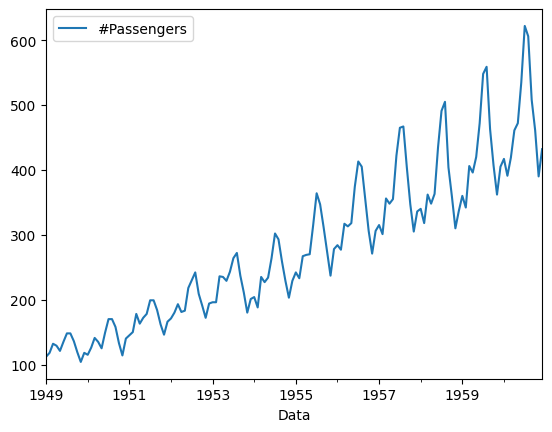

In [58]:
df.plot()

Apliquem ara el test de Dickey Fulley per comprovar l'estacionalitat.

In [59]:
# importem la classe adfuller de la llibreria statsmodels

from statsmodels.tsa.stattools import adfuller

# I l'apliquem a la columna de dades de la que 
# ens interessa conéixer l'estacionarietat

def mostraADF(serie):
    resultat = adfuller(serie);

    # I comprovem aquesta
    print('Estadística ADF: %f' % resultat[0])
    print('Probabilitat (p): %f' % resultat[1])
    print('valors crítics:')
    for key, value in resultat[4].items():
        print('\t%s: %.3f' % (key, value))

mostraADF(df["#Passengers"])

Estadística ADF: 0.815369
Probabilitat (p): 0.991880
valors crítics:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [60]:
import numpy as np

# Anem a aplicar una transformació logarítmica en altra columna
df["log_Passengers"]=np.log(df["#Passengers"])

<Axes: xlabel='Data'>

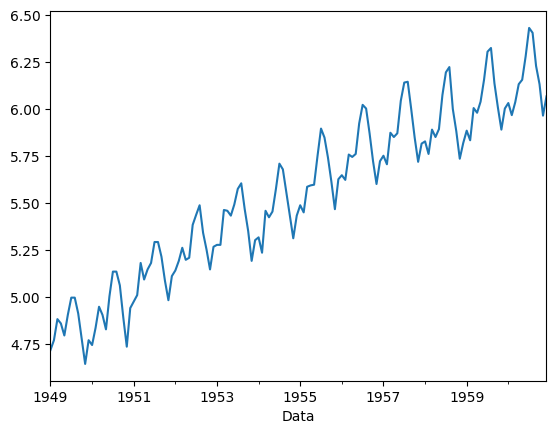

In [61]:
# Veiem la representació gràfica
df["log_Passengers"].plot()

In [62]:
# Veiem el resultat d'aplicar el test de Dickey-Fulley

mostraADF(df["log_Passengers"])

Estadística ADF: -1.717017
Probabilitat (p): 0.422367
valors crítics:
	1%: -3.482
	5%: -2.884
	10%: -2.579


Provem ara amb la diferenciació

In [63]:
df["dif_passengers"]=df["#Passengers"].diff()
# Eliminem nuls (La primera fila tindrà valor nul en dif_passengers)
df=df.dropna()

<Axes: xlabel='Data'>

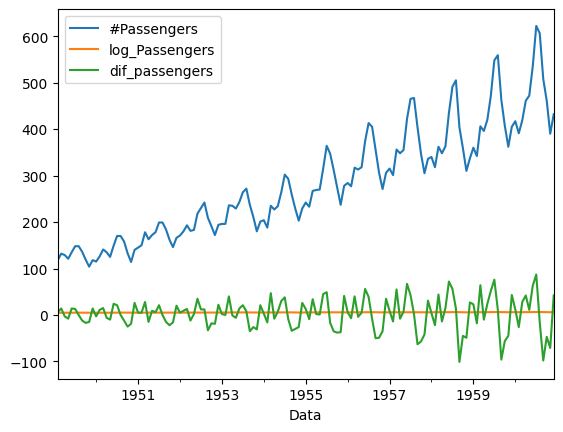

In [64]:
df.plot()

In [65]:
mostraADF(df["dif_passengers"])

Estadística ADF: -2.829267
Probabilitat (p): 0.054213
valors crítics:
	1%: -3.482
	5%: -2.884
	10%: -2.579


# Generació de lags

Abans de fer la divisió i entrenar l'algorisme, necessitem crear els lags corresponents. Afegirem 10 lags per a les dades transformades amb la transformació logarítmica i 10 lags més per a la diferenciació. Després a l'hora d'entrenar ja agafarem els subconjunts de columnes que necessitem. 

In [66]:
# Fem abans una còpia i treballem amb ella
df_work=df.copy()

# Amb això evitem l'advertència SettingwithCopyWarning
# Més info en: https://www.dataquest.io/blog/settingwithcopywarning/

In [67]:
# Generem els lags

for i in range(1, 11):
    df_work['Lag_log_' + str(i)] = df_work['log_Passengers'].shift(i)
    df_work['Lag_dif_' + str(i)] = df_work['dif_passengers'].shift(i)
    

In [68]:
# I eliminem els nuls
df_work=df_work.dropna()

# Generació dels conjunts de test i prova  i entrenament de l'algorisme

In [69]:
# Quantes files tenim?

df_work.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133 entries, 1949-12-01 to 1960-12-01
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Month           133 non-null    object 
 1   #Passengers     133 non-null    int64  
 2   log_Passengers  133 non-null    float64
 3   dif_passengers  133 non-null    float64
 4   Lag_log_1       133 non-null    float64
 5   Lag_dif_1       133 non-null    float64
 6   Lag_log_2       133 non-null    float64
 7   Lag_dif_2       133 non-null    float64
 8   Lag_log_3       133 non-null    float64
 9   Lag_dif_3       133 non-null    float64
 10  Lag_log_4       133 non-null    float64
 11  Lag_dif_4       133 non-null    float64
 12  Lag_log_5       133 non-null    float64
 13  Lag_dif_5       133 non-null    float64
 14  Lag_log_6       133 non-null    float64
 15  Lag_dif_6       133 non-null    float64
 16  Lag_log_7       133 non-null    float64
 17  Lag_dif_7       

In [70]:
# Amb 133 files, el conjunt de prova estaría sobre el 20% amb 26.

steps=26
train_set=df_work[:-steps]
test_set=df_work[-steps:]


In [71]:
# Dividim les variables de la variable objectiu

# Filtrem per obtenir les columnes logarítmiques
cols_log=cols = df_work.filter(like='Lag_log_').columns.to_list()
cols_log.append("#Passengers")
cols_log.append("log_Passengers")
cols_log.append("Month")
cols_log.append("dif_passengers") # Aquesta també caldrà eliminar-la

# I les columnes de diferències
cols_dif=cols = df_work.filter(like='Lag_dif_').columns.to_list()
cols_dif.append("#Passengers")
cols_dif.append("dif_passengers")
cols_dif.append("Month")
cols_dif.append("log_Passengers") # Aquesta també caldrà eliminar-la

In [72]:
# I fem la divisió per a cada cas

# Prèviament, anem a guardar-nos la columna de les
# etiquetes originals #Passengers, per comparar
# al final
Y_test=test_set["#Passengers"].copy()

# Divisió per a la transformació logarítmica
# Eliminant la informació de les diferències

X_train_log=train_set.drop(cols_dif, axis=1)
Y_train_log=train_set["log_Passengers"].copy()

X_test_log=test_set.drop(cols_dif, axis=1)
Y_test_log=test_set["log_Passengers"].copy()

# Divisió per a la diferenciació
# Eliminant la informació dels logs
X_train_dif=train_set.drop(cols_log, axis=1)
Y_train_dif=train_set["dif_passengers"].copy()

X_test_dif=test_set.drop(cols_log, axis=1)
Y_test_dif=test_set["dif_passengers"].copy()


In [73]:
# Ara ja podem generar els models i fer l'entrenament

from sklearn.linear_model import LinearRegression

model_log = LinearRegression()
model_log.fit(X_train_log, Y_train_log)

model_dif = LinearRegression()
model_dif.fit(X_train_dif, Y_train_dif)

LinearRegression()

In [74]:
# I llançar les prediccions

y_pred_log = model_log.predict(X_test_log)

y_pred_dif = model_dif.predict(X_test_dif)

In [75]:
# Definim algunes funcions d'utilitat
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


def mostraMetriques(y_test, y_pred):
    eam=mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print('EAM: %f' % eam)
    print('MSE: %f' % mse)
    print('RMSE: %f' % rmse)
    print('R2: %f' % r2)

import matplotlib.pyplot as plt

def dibuixaSerie(y_test, y_pred):

    # Creem un dataframe amb les prediccions
    y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['y_pred'])

    # Ordenem els índex
    y_test = y_test.sort_index()
    y_pred_df = y_pred_df.sort_index()

    # Dibuixa les dades
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Etiquetes reals')
    plt.plot(y_pred_df, label='Prediccions')
    plt.title('Comparació entre les etiquetes reals i les prediccions')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

In [76]:
print("Mètriques amb la transformació logarítmica")
mostraMetriques(Y_test_log, y_pred_log)

print("Mètriques amb diferenciació")
mostraMetriques(Y_test_dif, y_pred_dif)

Mètriques amb la transformació logarítmica
EAM: 0.072195
MSE: 0.006807
RMSE: 0.082504
R2: 0.779615
Mètriques amb diferenciació
EAM: 19.585362
MSE: 601.644122
RMSE: 24.528435
R2: 0.767491


En aquest cas, no podem contrastar EAM, MSE i RMSE, al tractar-se de diferents ordres de magnitud. Per altra banda, els índex R2 donen resultats similars (77% front al 76%).

Una vegada realitzades les prediccions sense estacionarietat, apliquem les transformacions inverses, per veure els resultats reals.

In [77]:
# Revertim la transformació logarítmica amb una exponencial
y_pred_log_original = np.exp(y_pred_log)

# I revertim la diferenciació amb la suma acumulada
y_pred_dif_original_tmp = np.cumsum(y_pred_dif)
# cumsum no retorna el primer valor original, i per tant
# sèrie se centraria al 0. Cal incorporar aquest valor, 
# per a la qual cosa cal "tornar enrere", tants passos com
# hàgem afagat.

primer_valor_orig = df["#Passengers"].iloc[-steps]
y_pred_dif_original = y_pred_dif_original_tmp + primer_valor_orig

In [78]:
# Si tornem a mostrar les mètriques:

print("Mètriques amb la transformació logarítmica")
mostraMetriques(Y_test, y_pred_log_original)

print("Mètriques amb diferenciació")
mostraMetriques(Y_test, y_pred_dif_original)

Mètriques amb la transformació logarítmica
EAM: 31.904327
MSE: 1392.563284
RMSE: 37.317064
R2: 0.780310
Mètriques amb diferenciació
EAM: 127.581233
MSE: 22789.900757
RMSE: 150.963243
R2: -2.595322


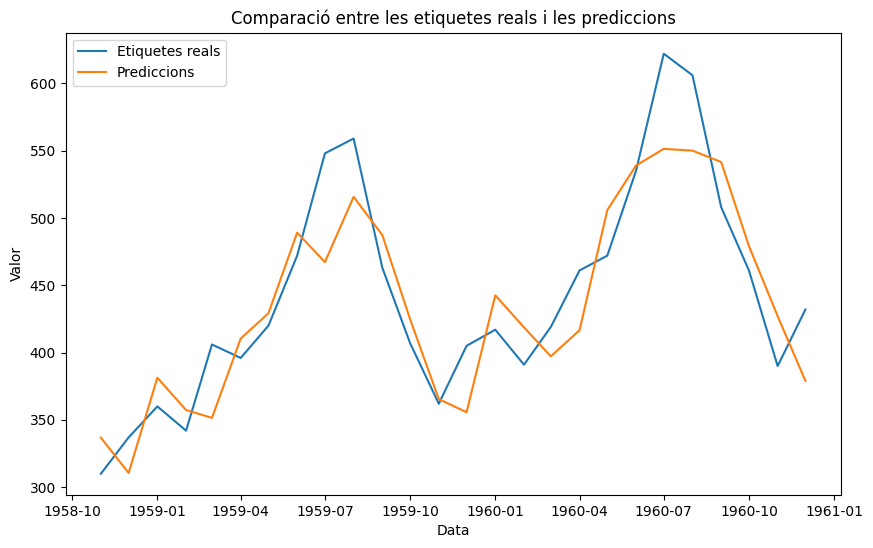

In [79]:
dibuixaSerie(Y_test, y_pred_log_original)

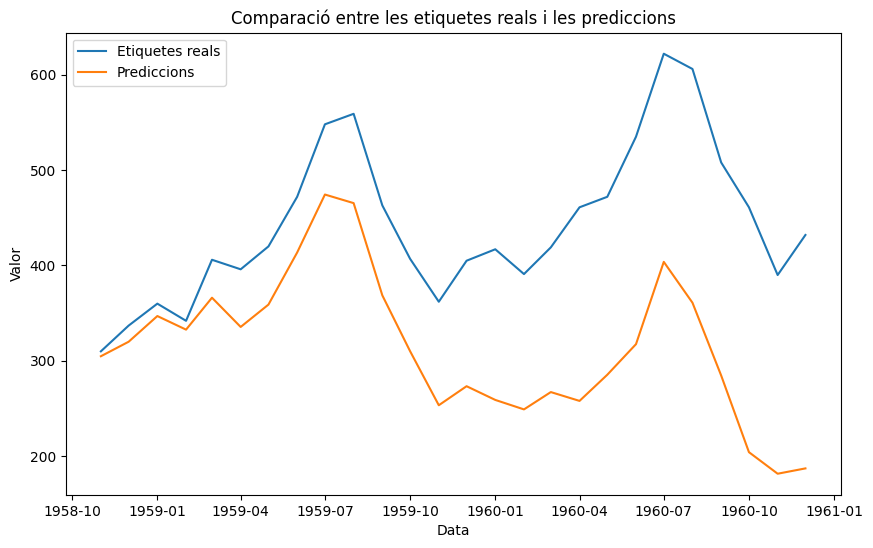

In [80]:
dibuixaSerie(Y_test, y_pred_dif_original)